# TEAM NAME:  PINAKA

# Project Name: AutoPack-Computer Vision for Optimal Package Selection
## MEMBERS: 
 * Akshit V V
 * Ankith C S
 * Panshul Humad
 * Ayush Adarsh
                   

In [34]:
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import numpy as np
import imutils
import cv2
import numpy as np
import itertools
# import streamlit as st
from PIL import Image
import matplotlib.pyplot as plt

In [35]:
def mid_point(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

In [36]:
def dim_predict(image_path, leftmostWidth):
    #Load the image, convert it to grayscale, and blur it slightly
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (7, 7), 0)

    # Perform edge detection, then perform a dilation + erosion to close gaps in between object edges
    edged = cv2.Canny(gray, 50, 100)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)

    # Find contours in the edge map
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    # Sort the contours from left-to-right and initialize the 'pixels per metric' calibration variable
    (cnts, _) = contours.sort_contours(cnts)
    pixelsPerMetric = None

    # Find the leftmost contour
    leftmostX = None
    for c in cnts:
        if cv2.contourArea(c) < 100:
            continue
        box = cv2.minAreaRect(c)
        box = cv2.boxPoints(box)
        box = np.array(box, dtype="int")
        box = perspective.order_points(box)
        (x, y, w, h) = cv2.boundingRect(box.astype("int"))
        if leftmostX is None or x < leftmostX:
            leftmostX = x
            leftmostBox = box

    # Calculate the pixelsPerMetric
    midpoint = ((leftmostBox[0][0] + leftmostBox[1][0]) // 2, (leftmostBox[0][1] + leftmostBox[1][1]) // 2)
    pixelsPerMetric = np.abs(midpoint[0] - leftmostX) / leftmostWidth
    
    
    # Calculate the size of the leftmost object
    (leftmostWidth, leftmostHeight) = (leftmostBox[1][0] - leftmostBox[0][0], leftmostBox[2][1] - leftmostBox[0][1])
    leftmostSize = (leftmostWidth / pixelsPerMetric, leftmostHeight / pixelsPerMetric)
    # print(leftmostSize)
    
    # Loop over the contours individually
    for c in cnts:
        # If the contour is not sufficiently large, ignore it
        if cv2.contourArea(c) < 100:
            continue
        # Compute the rotated bounding box of the contour
        orig = image.copy()
        box = cv2.minAreaRect(c)
        box = cv2.boxPoints(box)  # Removed the conditional statement for cv2.cv.BoxPoints
        box = np.array(box, dtype="int")
        # Order the points in the contour such that they appear
        # in top-left, top-right, bottom-right, and bottom-left order, then draw the outline of the rotated bounding box
        box = perspective.order_points(box)
        cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)
        # Loop over the original points and draw them
        for (x, y) in box:
            cv2.circle(orig, (int(x), int(y)), 5, (0, 0, 255), -1)

        # unpack the ordered bounding box, then compute the midpoint between the top-left and top-right coordinates, followed by the midpoint between bottom-left and bottom-right coordinates
        (tl, tr, br, bl) = box
        (tltrX, tltrY) = mid_point(tl, tr)
        (blbrX, blbrY) = mid_point(bl, br)
        # compute the midpoint between the top-left and top-right points, followed by the midpoint between the top-right and bottom-right
        (tlblX, tlblY) = mid_point(tl, bl)
        (trbrX, trbrY) = mid_point(tr, br)
        # draw the midpoints on the image
        cv2.circle(orig, (int(tltrX), int(tltrY)), 5, (255, 0, 0), -1)
        cv2.circle(orig, (int(blbrX), int(blbrY)), 5, (255, 0, 0), -1)
        
        cv2.circle(orig, (int(tlblX), int(tlblY)), 5, (255, 0, 0), -1)
        cv2.circle(orig, (int(trbrX), int(trbrY)), 5, (255, 0, 0), -1)
        # draw lines between the midpoints
        cv2.line(orig, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)), (255, 0, 255), 2)
        cv2.line(orig, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)), (255, 0, 255), 2)

        # compute the Euclidean distance between the midpoints
        dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
        dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))

        # compute the size of the object
        dimA = dA / pixelsPerMetric
        dimB = dB / pixelsPerMetric

        # draw the object sizes on the image
        cv2.putText(orig, "{:.1f}in".format(dimA), (int(tltrX - 15), int(tltrY - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255, 255, 255), 2)
        cv2.putText(orig, "{:.1f}in".format(dimB), (int(trbrX + 10), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255, 255, 255), 2)

    
    # Return the dimensions
    return dimA, dimB

In [38]:
def dim_out(image_top, image_side, leftmostWidth):
    dimensions_1 = dim_predict(image_top, leftmostWidth)
    dimensions_2 = dim_predict(image_side, leftmostWidth)
    length = dimensions_1[1]
    breadth = dimensions_1[0]
    height = dimensions_2[0]
    return [length, breadth, height]

In [39]:
# Define the box sizes and volumes
boxes = [
    {"size": "A1", "dimensions": (3, 3, 3), "volume": 27},
    {"size": "A2", "dimensions": (4, 4, 4), "volume": 64},
    {"size": "A3", "dimensions": (5, 5, 5), "volume": 125},
    {"size": "B1", "dimensions": (6, 6, 6), "volume": 216},
    {"size": "B2", "dimensions": (7, 7, 7), "volume": 343},
    {"size": "B3", "dimensions": (8, 8, 8), "volume": 512},
    {"size": "C1", "dimensions": (9, 9, 9), "volume": 729},
    {"size": "C2", "dimensions": (10, 10, 10), "volume": 1000},
    {"size": "C3", "dimensions": (11, 11, 11), "volume": 1331},
    {"size": "D1", "dimensions": (12, 12, 12), "volume": 1728},
    {"size": "D2", "dimensions": (13, 13, 13), "volume": 2197},
    {"size": "D3", "dimensions": (14, 14, 14), "volume": 2744},
    {"size": "E1", "dimensions": (15, 15, 15), "volume": 3375},
]

In [41]:
def find_optimal_box(dimensions, free_volume_percent=0):
    length, breadth, height = dimensions
    # Calculate the volume of the object
    object_volume = length * breadth * height
    # Calculate the required volume including the free volume percentage
    required_volume = object_volume * (1 + free_volume_percent / 100.0)
    
    # Find the smallest box that can fit the object
    suitable_boxes = []
    for box in boxes:
        box_volume = box["volume"]
        box_dims = box["dimensions"]
        if (length <= box_dims[0] and breadth <= box_dims[1] and height <= box_dims[2]) and box_volume >= required_volume:
            suitable_boxes.append(box)
    
    # Sort suitable boxes by volume in ascending order
    suitable_boxes = sorted(suitable_boxes, key=lambda x: x["volume"])
    
    if suitable_boxes:
        optimal_box = suitable_boxes[0]
        return optimal_box["size"], optimal_box["dimensions"]
    else:
        return None, None

### BIN IMPLEMENTATION

In [30]:
def find_min_bounding_box(boxes):
    min_volume = float('inf')
    best_combination = None
    best_positions = None
    best_orientation = None

    # Generate all possible orientations of each box
    orientations = [list(itertools.permutations(box)) for box in boxes]

    # Generate all possible stacking configurations
    for combination in itertools.product(*orientations):
        for axes in itertools.permutations([0, 1, 2]):
            positions = [(0, 0, 0) for _ in combination]
            current_position = [0, 0, 0]
            max_extent = [0, 0, 0]

            # Initialize a list to track the occupied space
            occupied_space = []

            for i, box in enumerate(combination):
                # Set the position of the box
                positions[i] = tuple(current_position)

                # Update the max extent based on the current box
                max_extent[0] = max(max_extent[0], current_position[0] + box[0])
                max_extent[1] = max(max_extent[1], current_position[1] + box[1])
                max_extent[2] = max(max_extent[2], current_position[2] + box[2])

                # Check for overlaps with previously placed boxes
                if any(is_overlapping(positions[j], combination[j], current_position, box) for j in range(i)):
                    break  # Overlap detected, skip this configuration
                else:
                    # Update the current position for the next box
                    if axes[0] == 0:
                        current_position[0] += box[0]
                    elif axes[0] == 1:
                        current_position[1] += box[1]
                    elif axes[0] == 2:
                        current_position[2] += box[2]

                    # Add the current box to occupied space
                    occupied_space.append((positions[i], box))

            # Calculate the volume of the bounding box
            volume = max_extent[0] * max_extent[1] * max_extent[2]

            # Update the minimum volume and best configuration if applicable
            if volume < min_volume:
                min_volume = volume
                best_combination = combination
                best_positions = positions
                best_orientation = axes

    return best_combination, best_positions, best_orientation, min_volume

In [31]:
def is_overlapping(pos1, box1, pos2, box2):
    # Check if box1 at pos1 overlaps with box2 at pos2
    box1_min = pos1
    box1_max = (pos1[0] + box1[0], pos1[1] + box1[1], pos1[2] + box1[2])
    
    box2_min = pos2
    box2_max = (pos2[0] + box2[0], pos2[1] + box2[1], pos2[2] + box2[2])

    return not (box1_max[0] <= box2_min[0] or box1_min[0] >= box2_max[0] or
                box1_max[1] <= box2_min[1] or box1_min[1] >= box2_max[1] or
                box1_max[2] <= box2_min[2] or box1_min[2] >= box2_max[2])

In [32]:
best_combination, positions, best_orientation, min_volume = find_min_bounding_box(input_boxes)

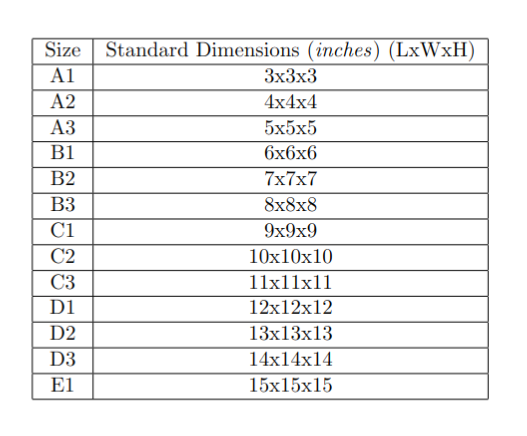

In [33]:
# Take input for leftmostWidth
leftmostWidth = float(input("Enter the leftmost width: "))

# Take input for multiple images
multiple_images = input("Do you want to enter multiple images? (Yes/No): ")

if multiple_images.lower() == "yes":
    num_images = int(input("Enter the number of images: "))
    input_boxes = []
    for i in range(num_images):
        image_top_path = input(f"Enter the path to top image for image {i+1}: ")
        image_top_array = cv2.imread(image_top_path)
        
        image_side_path = input(f"Enter the path to side image for image {i+1}: ")
        image_side_array = cv2.imread(image_side_path)
        
        dimensions = dim_out(image_top_array, image_side_array, leftmostWidth)
        input_boxes.append(dimensions)
else:
    image_top_path = input("Enter the path to top image: ")
    image_top_array = cv2.imread(image_top_path)
    
    image_side_path = input("Enter the path to side image: ")
    image_side_array = cv2.imread(image_side_path)
    
    dimensions = dim_out(image_top_array, image_side_array, leftmostWidth)
    input_boxes = [dimensions]

# Show output
if input_boxes:
    best_combination, positions, best_orientation, min_volume = find_min_bounding_box(input_boxes)
    bounding_box_dimensions = (
        max([pos[0] + box[0] for pos, box in zip(positions, best_combination)]),
        max([pos[1] + box[1] for pos, box in zip(positions, best_combination)]),
        max([pos[2] + box[2] for pos, box in zip(positions, best_combination)])
    )
    sorted_list = sorted(bounding_box_dimensions, reverse=True)
    increased_list = [x * 1.10 for x in sorted_list]
    bounding_box_dimensions = tuple(increased_list)
    box_size, box_dimensions = find_optimal_box(bounding_box_dimensions, 10)
    if box_size:
        print(f"The optimal box size is: {box_size}")
        print(f"Dimensions: {box_dimensions}")
    else:
        print("No suitable box found.")



Enter the leftmost width: 0.39
Do you want to enter multiple images? (Yes/No): yes
Enter the number of images: 2
Enter the path to top image for image 1: /home/akshit/Desktop/pinaka/production/1.013/test/a1.jpg
Enter the path to side image for image 1: /home/akshit/Desktop/pinaka/production/1.013/test/a2.jpg
Enter the path to top image for image 2: /home/akshit/Desktop/pinaka/production/1.013/test/b1.jpg
Enter the path to side image for image 2: /home/akshit/Desktop/pinaka/production/1.013/test/b2.jpg
The optimal box size is: B1
Dimensions: (6, 6, 6)


/tmp/ipykernel_7353/1289787081.py:50: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
